# Poisson GPLVM with circular latent variables

GPLVM with a [circular latent space](https://proceedings.neurips.cc/paper/2020/hash/fedc604da8b0f9af74b6cfc0fab2163c-Abstract.html) suitable to model latent variables on a ring, [extended](https://www.biorxiv.org/content/10.1101/2022.05.11.490308v2) with a temporal AR(1) prior for the latent variables and Poisson observations.

### Table of contents

1. [**Synthetic head direction cell population**](#synthetic)
1. [**Fit GPLVM model**](#fit)
3. [**Evaluate latent space**](#latent)
4. [**Evaluate tuning curve**](#tuning)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter

import matplotlib.pyplot as plt

import numpy as np


import sys
sys.path.append("..")

import neuroprob as nprb
from neuroprob import utils


dev = nprb.inference.get_device()

PyTorch version: 1.13.1+cu117
Using device: cuda:0


In [2]:
# seed everything
seed = 123
torch.manual_seed(seed)
rng = np.random.default_rng(seed)  # seed RNG

<a id="synthetic"></a>
## 1. Synthetic head direction cell population

In [3]:
def HDC_bumps(theta, A, invbeta, b, theta_0):
    """
    parameters have shape (neurons,)
    :return:
        rates of shape (..., neurons, eval_pts)
    """
    return A[:, None] * np.exp(
        (np.cos(theta[..., None, :] - theta_0[:, None]) - 1) / invbeta[:, None]) + b[:, None]


In [4]:
# Gaussian von Mises bump head direction model
trials = 1

track_samples = 20000
hd_t = np.empty((trials, track_samples))

hd_t[:, 0] = rng.normal(size=(trials,))*2*np.pi
rn = rng.normal(size=(trials, track_samples-1))
for k in range(track_samples-1):
    hd_t[:, k+1] = hd_t[:, k] + 0.05*rn[:, k]
    
hd_t = hd_t % (2*np.pi)

# tuning
neurons = 50
p_c = rng.normal(size=(neurons,))**2 + 1.0
p_a = np.maximum(0.0, 30.0 + 0.1*rng.normal(size=(neurons,)))
p_b = 0.2*rng.normal(size=(neurons,))**2 + 0.3
p_z = np.linspace(0, 2*np.pi, neurons+1)[:-1]

rate = HDC_bumps(hd_t, p_a, p_b, p_c, p_z)  # (tr, neurons, ts)

In [5]:
# IPP spike trains
sample_bin = 0.001
res = rng.poisson(rate*sample_bin)

res_ind = [] # spike times
for tr in range(trials):
    res_ind_ = []
    for n in range(neurons):
        res_ind_.append(utils.neural.binned_to_indices(res[tr, n, :]))
    res_ind.append(res_ind_)

# bin data
bin_size = 20

rc_t = []
rhd_t = []
for tr in range(trials):
    tbin, resamples, rc_t_, (rhd_t_,) = utils.neural.bin_data(bin_size, sample_bin, res_ind[tr], 
                                                            track_samples, (hd_t[tr],), average_behav=False)
    
    rc_t.append(rc_t_)
    rhd_t.append(rhd_t_)
    
rc_t = np.array(rc_t)
rhd_t = np.array(rhd_t)

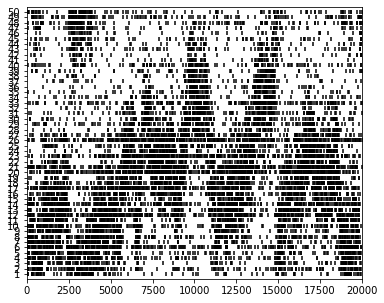

In [6]:
tr = 0

fig, ax = plt.subplots(figsize=(6,5))
utils.plots.raster_plot((fig, ax), res[tr], track_samples, sample_bin*1000, neurons, markersize=10)
#utils.plot.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')
plt.show()

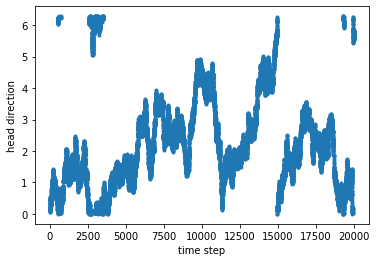

In [7]:
plt.figure()
plt.scatter(np.arange(track_samples), hd_t[tr], marker='.')
plt.ylabel('head direction')
plt.xlabel('time step')
plt.show()

<a id='fit'></a>
## 2. Fit GPLVM model

Ring topology for the latent space.

In [8]:
out_dims = neurons

# kernel
l = 5.*torch.ones(1, out_dims)
v = torch.ones(out_dims)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.SquaredExponential(
    input_dims=len(l), lengthscale=l, \
    track_dims=[0], topology='ring', f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inputs
p = nprb.inputs.priors.tAR1(
    torch.tensor(0.), 
    torch.tensor(4.0), 
    'ring', 
    1, 
)
v = nprb.inputs.variational.IndNormal(
    torch.rand(resamples, 1) * 2*np.pi, 
    torch.ones((resamples, 1)) * 0.1, 
    'ring', 
    1, 
)
input_data = [nprb.inputs.prior_variational_pair(1, p, v)]

input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, resamples, batch_info=500, trials=trials)

# inducing points
num_induc = 8
Xu = np.array(
    [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
).T[None, ...].repeat(out_dims, axis=0)
inducing_points = nprb.mappings.inducing_points(
    out_dims, torch.from_numpy(Xu), jitter=1e-5)


# mapping
in_dims = Xu.shape[-1]

gp = nprb.mappings.SVGP(
    in_dims, neurons, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(neurons), learn_mean=True
)

# likelihood
likelihood = nprb.likelihoods.discrete.Poisson(tbin, neurons, 'exp')
likelihood.set_Y(torch.from_numpy(rc_t), batch_info=500) 

# assemble
gplvm = nprb.inference.VI_optimized(input_group, gp, likelihood)
gplvm.to(dev)

VI_optimized(
  (input_group): input_group(
    (input_0): prior_variational_pair(
      (prior): tAR1(
        (transition): transition_()
      )
      (variational): IndNormal()
    )
  )
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Poisson()
)

In [9]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_lr_dict = {
    'default': 5*1e-3, 
    'input_group.input_0.variational.finv_std': 5*1e-3,  
}

gplvm.set_optimizers(optim.Adam, sch, 100, opt_lr_dict)

annealing = lambda x: 1.0
losses = gplvm.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=2, ll_samples=2, ll_mode='MC')

  0%|          | 0/3000 [00:00<?, ?it/s]


Stopped at epoch 1659.


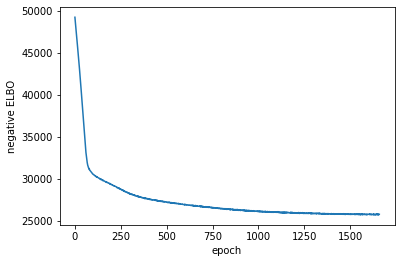

In [10]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.show()

<a id='latent'></a>
## 3. Evaluate latent space

In [11]:
# align latent
def signed_scaled_shift(
    x, x_ref, dev="cpu", iters=1000, lr=1e-2, learn_scale=True
):
    """
    Shift trajectory, with scaling, reflection and translation.

    Shift trajectories to be as close as possible to each other, including
    switches in sign.

    :param np.array theta: circular input array of shape (timesteps,)
    :param np.array theta_ref: reference circular input array of shape (timesteps,)
    :returns:
        tuple of shifted latents (ts,), shift, sign, scale, losses
    """
    def metric(x, y):
        """
        Returns the geodesic displacement between x and y, (x-y).

        :param torch.tensor x: input x of any shape
        :param torch.tensor y: input y of same shape as x
        :returns: x-y tensor of geodesic distances
        :rtype: torch.tensor
        """
        xy = (x - y) % (2 * np.pi)
        xy[xy > np.pi] -= 2 * np.pi
        return xy

    XX = torch.tensor(x, device=dev)
    XR = torch.tensor(x_ref, device=dev)

    lowest_loss = np.inf
    for sign in [1, -1]:  # select sign automatically
        shift = Parameter(torch.zeros(1, device=dev))
        p = [shift]

        if learn_scale:
            scale = Parameter(torch.ones(1, device=dev))
            p += [scale]
        else:
            scale = torch.ones(1, device=dev)

        optimizer = optim.Adam(p, lr=lr)
        losses = []
        for k in range(iters):
            optimizer.zero_grad()
            X_ = XX * sign * scale + shift
            loss = (metric(X_, XR) ** 2).mean()
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())

        l_ = loss.cpu().item()

        if l_ < lowest_loss:
            lowest_loss = l_
            shift_ = shift.cpu().item()
            scale_ = scale.cpu().item()
            sign_ = sign
            losses_ = losses

    return x * sign_ * scale_ + shift_, shift_, sign_, scale_, losses_

In [12]:
X_loc, X_std = gplvm.input_group.input_0.variational.eval_moments(0, resamples)
X_loc = X_loc.data.cpu().numpy()
X_std = X_std.data.cpu().numpy()

lat_t, shift, sign, scale, _ = signed_scaled_shift(X_loc[:, 0], rhd_t, dev)
lat_std = X_std[:, 0]

/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


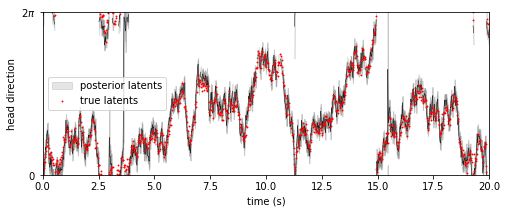

In [13]:
# circular posterior
T = lat_t.shape[0]
times = tbin*np.arange(T)


fig, ax = plt.subplots(figsize=(8,3))
ax.set_xlim([0, tbin*T])
ax.set_ylim([0, 2*np.pi])
ax.set_yticks([0, 2*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$'])
ax.set_xlabel('time (s)')
ax.set_ylabel('head direction')

utils.plots.plot_circ_posterior(
    ax, times, lat_t, lat_std, col='k', linewidth=0.5, step=1, alpha=0.1, line_alpha=1., 
    l=None, l_std='posterior latents'
)

ax.scatter(times, rhd_t[:T], marker='.', s=3, color='r', zorder=2, label='true latents')
ax.legend()


plt.show()


<a id='tuning'></a>
## 4. Evaluate tuning curves

In [14]:
# tuning curves
steps = 100
show_neurons = [0, 1, 20]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]  # (dims, timesteps)
MC = 1000
shift_covs = (covariates - shift) / sign

samples = utils.model.marginal_posterior_samples(
    gp, likelihood.f, torch.from_numpy(shift_covs), MC, show_neurons)
lower, median, upper = [
    p.cpu().numpy() for p in utils.stats.percentiles_from_samples(samples, smooth_length=5)
]

r_true = HDC_bumps(covariates[0, :], p_a, p_b, p_c, p_z)

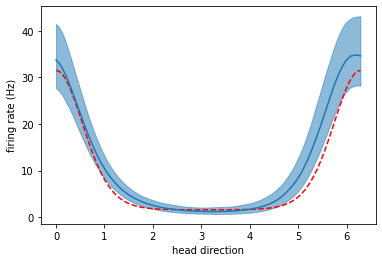

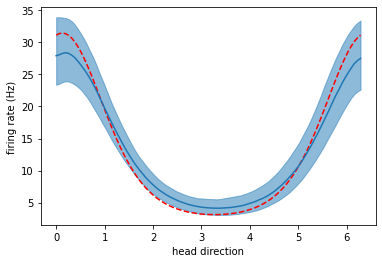

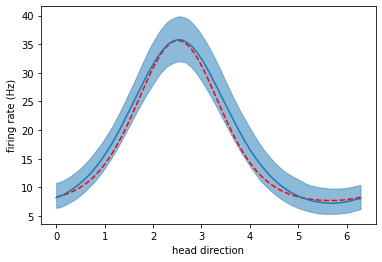

In [15]:
for k, neuron in enumerate(show_neurons):

    fig, ax = plt.subplots()
    ax.plot(covariates[0], r_true[neuron], 'r--')
    line, = ax.plot(covariates[0], median[k])
    ax.fill_between(
        covariates[0], lower[k],
        upper[k], color=line.get_color(), alpha=0.5
    )
    ax.set_xlabel('head direction')
    ax.set_ylabel('firing rate (Hz)')

plt.show()